In [2]:
import numpy as np
from sklearn.cluster import SpectralClustering,KMeans
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef,accuracy_score,precision_score,recall_score,confusion_matrix
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import os

In [3]:
outputfolder="figures/"

# HL: evaluate this sample
datatype="HEK293T_WT_directRNA" 
# HL: use this model
modelname="hg38retrain_HEK293T_KO1_chrsplitHEK293T_WT_directRNA_epochs1_100_epochs2_88" 
os.makedirs(outputfolder+"/"+modelname+"/",exist_ok = True)

In [4]:
# HL: transfer from dataden "/umms-kinfai/duolin/ying/reditools2_candidates/"
hash_candidat={}
hash_candidat['AFG-H1_directRNA']='H1-AFG.candidate_sites.tab'
hash_candidat['AFG-H9_directRNA']='H9-AFG.candidate_sites.tab'
hash_candidat["PGC-H1_directRNA"]='H1-PGC.candidate_sites.tab'
hash_candidat["DE-H1_directRNA"]='H1-DE.candidate_sites.tab'
hash_candidat["DE-H9_directRNA"]='H9-DE.candidate_sites.tab'
hash_candidat["GM12878_directRNA"]='GM12878.candidate_sites.tab'
hash_candidat["H1-hESC_directRNA"]='H1-hESC.candidate_sites.tab'
hash_candidat["H9-hESC_directRNA"]='H9-hESC.candidate_sites.tab'
hash_candidat['HEK293T_DKO_directRNA']='HEK293T_WT.candidate_sites.tab'
hash_candidat["HEK293T_WT_directRNA"]='HEK293T_WT.candidate_sites.tab'
hash_candidat["HEK_WT_pass"]='HEK293T_WT.candidate_sites.tab'
candidatefile="/nfs/turbo/umms-kinfai/haorli/20240314_ReDD_result_data/figure2a/reditools2_candidates/"+hash_candidat[datatype]


In [5]:
long_reads_min_coverage = coverage_cutoff = 5

In [6]:
covfilename=5
datatype='HEK293T_WT_directRNA'
includesnp=False #False
outputfolder="figures"

#REDD
featuredim=5
windowsize=9
inputfolder="/nfs/turbo/umms-kinfai/haorli/20240314_ReDD_result_data/figure2a/REDD/"
modelname = 'hg38retrain_HEK293T_KO1_chrsplitHEK293T_WT_directRNA_epochs1_100_epochs2_88'

try:
    os.makedirs(outputfolder+"/"+modelname+"/")
except:
    pass
filename1=modelname+"/test_"+datatype+"_onlycandidate_cov"+str(covfilename)+"_ratio0_modcov0.sitelev.bed" #background must use no filter except coverage
filename2=modelname+"/test_"+datatype+"_noncandidate_cov"+str(covfilename)+"_ratio0_modcov0.sitelev.bed"

In [7]:
# HL: define ground truth
negative_site = "/nfs/turbo/umms-kinfai/haorli/20240314_ReDD_result_data/figure3a/negative_site/test_HEK293T_WT_negative_sites_rthred0.1.txt"
positive_site = "/nfs/turbo/umms-kinfai/haorli/20240314_ReDD_result_data/figure3a/positive_site/test_HEK293T_WT_positive_sites_rthred0.1.txt"

using_mean_prediction_score=True
if using_mean_prediction_score:
   score_index=-1
else:
   score_index=-2

true_candidate_ratios={}
input = open(candidatefile,'r')
for line in input:
    chr_ = line.split()[0]
    pos_ = line.split()[1].strip()
    true_candidate_ratios[chr_+"-"+pos_]=float(line.split("\t")[3])

nonmodification_sites={}
input = open(negative_site,'r')
for line in input:
    chr_ = line.split("-")[0]
    pos_ = line.split("-")[1].strip()
    nonmodification_sites[chr_+"-"+pos_]=1

positive_sites={}
input = open(positive_site,'r')
for line in input:
    chr_ = line.split("-")[0]
    pos_ = line.split("-")[1].strip()
    positive_sites[chr_+"-"+pos_]=1

In [8]:
# HL: REDD prediction results
REDD_true_value_all={}
REDD_predict_value_all={} #909
num_candidate=0
#index_neg=[]
inputs=[open(inputfolder+"/"+filename1),open(inputfolder+"/"+filename2)]
for input in inputs:
  for line in input:
    readcoverage=int(line.split()[3])
    if readcoverage<coverage_cutoff:
         continue
    
    chr_ = line.split()[0]
    pos_ = line.split()[1]
    if len(line.split("\t")) == 6:
        predictscore=float(line.split("\t")[score_index]) #last score is mean prediciton score
    else:
        predictscore=float(line.split("\t")[-1]) #for old result there is no mean prediction scores
    
    if chr_+"-"+pos_ in positive_sites:
         REDD_true_value_all[chr_+"-"+pos_]=true_candidate_ratios[chr_+"-"+pos_]
    elif chr_+"-"+pos_ in nonmodification_sites:
         REDD_true_value_all[chr_+"-"+pos_]=0
         #index_neg.append(len(REDD_true_value_all)-1)
    else:
         continue
    
    REDD_predict_value_all[chr_+"-"+pos_]=predictscore

In [9]:
# HL: Dinopore prediction results
inputfolderdinopore="/nfs/turbo/umms-kinfai/haorli/20240314_ReDD_result_data/figure2a/Dinopore/"

filenames=["Testinputschr3chr11.output_prediction_CNN_class0.txt","Testinputschr3chr11.output_prediction_CNN_class1.txt","Testinputschr3chr11.output_prediction_CNN_class2.txt"]
count = 0
Dinopore_true_value_all={}
Dinopore_predict_value_all={} #975
Dinopore_ratio_all = {}
for file in filenames:
    input=open(inputfolderdinopore+"/"+file)
    for line in input:
        if "contig" not in line:
             chr_=line.split()[0]
             pos_=line.split()[1]
             poskey=chr_+"-"+pos_
             readcoverage=int(line.split()[3])
             if readcoverage<coverage_cutoff:
                  continue
             
             if poskey in positive_sites:
                 Dinopore_true_value_all[poskey]=true_candidate_ratios[poskey]
                 Dinopore_predict_value_all[poskey]=float(line.split()[5])
             elif poskey in nonmodification_sites:
                 Dinopore_true_value_all[poskey]=0
                 Dinopore_predict_value_all[poskey]=float(line.split()[5])
             if len(line.split())==11:
                 Dinopore_ratio_all[poskey] = float(line.split()[10])
             else:
                 Dinopore_ratio_all[poskey] = 0
            

In [10]:
#for DeepEdit method
DeepEdit_true_value_all={}
DeepEdit_predict_value_all={} #856
inputfolderdeepedit = "/nfs/turbo/umms-kinfai/haorli/20240314_ReDD_result_data/figure2a/DeepEdit/Editing_ratio_genome.txt"
#Dinopore_index_neg=[]
for file in filenames:
    input=open(inputfolderdeepedit)
    for line in input:
             poskey=line.split()[0]
             readcoverage=int(line.split()[1])
             if readcoverage<coverage_cutoff:
                  continue
             
             if poskey in positive_sites:
                 DeepEdit_true_value_all[poskey]=true_candidate_ratios[poskey]
                 DeepEdit_predict_value_all[poskey]=float(line.split()[2])/float(line.split()[1])
             elif poskey in nonmodification_sites:
                 DeepEdit_true_value_all[poskey]=0
                 DeepEdit_predict_value_all[poskey]=float(line.split()[2])/float(line.split()[1])

In [11]:
#merge all results using common sites
true_value_selected=[]
REDD_predict_value_selected=[]
Dinopore_predict_value_selected=[]
DeepEdit_predict_value_selected=[] 
coord_list = []
for key in Dinopore_true_value_all:
  if key in REDD_true_value_all:
      if key in DeepEdit_true_value_all:
        true_value_selected.append(REDD_true_value_all[key])
        REDD_predict_value_selected.append(REDD_predict_value_all[key])
        Dinopore_predict_value_selected.append(Dinopore_predict_value_all[key])
        DeepEdit_predict_value_selected.append(DeepEdit_predict_value_all[key])
        coord_list.append(key)

true_value_selected=np.asarray(true_value_selected)
REDD_predict_value_selected=np.asarray(REDD_predict_value_selected)
Dinopore_predict_value_selected=np.asarray(Dinopore_predict_value_selected)
DeepEdit_predict_value_selected=np.asarray(DeepEdit_predict_value_selected)
coord_list = np.asarray(coord_list)
pos_coverage_ratio=0.1

# # # balance pos and neg
pos_index=np.where(true_value_selected>=pos_coverage_ratio)[0]
neg_index=np.where(true_value_selected==0)[0]
# pos_index=np.where(true_value_selected!=0)[0]
# neg_index=np.where(true_value_selected==0)[0][:len(pos_index)]
# neg_index = np.random.choice(np.where(true_value_selected==0)[0],len(pos_index))

coord_selected = np.concatenate([coord_list[pos_index],coord_list[neg_index]])
true_value_selected=np.concatenate([true_value_selected[pos_index],true_value_selected[neg_index]])
Dinopore_predict_value_selected=np.concatenate([Dinopore_predict_value_selected[pos_index],Dinopore_predict_value_selected[neg_index]])
REDD_predict_value_selected=np.concatenate([REDD_predict_value_selected[pos_index],REDD_predict_value_selected[neg_index]])
DeepEdit_predict_value_selected = np.concatenate([DeepEdit_predict_value_selected[pos_index],DeepEdit_predict_value_selected[neg_index]])

In [12]:
def check_site_in_range(site,example_chr,example_start,example_end):
    rname,pos = site.split('-')
    if rname == example_chr:
        if int(pos) >= example_start:
            if int(pos) <= example_end:
                return True
    return False

In [13]:
example_chr = 'chr3'
example_start = 136334873
example_end = 136335709

In [14]:
import pandas as pd
df = pd.DataFrame([coord_selected,true_value_selected,REDD_predict_value_selected,Dinopore_predict_value_selected,DeepEdit_predict_value_selected]).T
df.columns = ['Site','truth_ratio','ReDD_ratio','Dinopore_prob','DeepEdit_ratio']

example_df = df[df['truth_ratio'] >= pos_coverage_ratio]

example_df = example_df[example_df['Site'].apply(lambda x:check_site_in_range(x,example_chr,example_start,example_end))]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family '

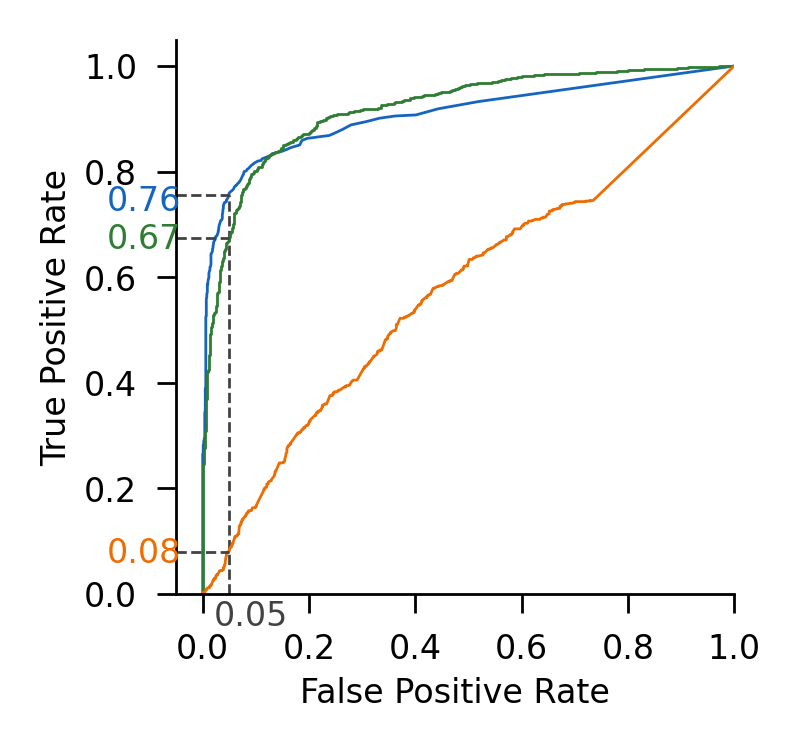

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# from matplotlib import colors
plt.style.use('ggplot')
plt.style.use('~/tidyplot.mplstyle')
grey_color='#424242'
# colors=['#42a5f5','#66bb6a','#ffb74d','#81c784']
second_colors =['#1565c0','#2e7d32','#ef6c00','#81c784']
colors=['#1565c0','#2e7d32','#ef6c00','#81c784']
methods = ['ReDD','Dinopore','DeepEdit']
lw = 0.5
labels= []
# plt.clf()
# plt.cla()
fig,ax = plt.subplots(figsize=(1.8,1.8))
# params = {
#      'figure.figsize': (6, 6),
#      'axes.labelsize': '12',
#      'axes.titlesize':'12',
#      'xtick.labelsize':'12',
#      'ytick.labelsize':'12'}

# plt.rcParams.update(params)
selected_tpr = []
from sklearn.metrics import roc_curve, auc
#REDD
true_value_selected = (np.asarray(true_value_selected) >= pos_coverage_ratio).astype(int) 
fpr, tpr,thres = roc_curve(true_value_selected, REDD_predict_value_selected)
sel_fpr = fpr[np.abs(fpr - 0.05).argmin()]
sel_tpr = tpr[np.abs(fpr - 0.05).argmin()]
sel_thres = thres[np.abs(fpr - 0.05).argmin()]
redd_thres = sel_thres
selected_tpr.append(sel_tpr)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, color=colors[0], linewidth=lw)

label='ReDD (AUC: %0.3f)' % (roc_auc)
labels.append(label)

ax.hlines(linestyles='dashed',xmin = -0.05, xmax = sel_fpr, y = sel_tpr,
           colors =grey_color)
ax.vlines(linestyles='dashed',x = sel_fpr, ymin = 0, ymax = sel_tpr,
           colors =grey_color)
ax.text(-0.18,sel_tpr-0.03,round(sel_tpr,2),color=second_colors[0])

precision, recall, thresholds = precision_recall_curve(true_value_selected, REDD_predict_value_selected)
sel_precision = precision[np.abs(thresholds - sel_thres).argmin()]
sel_recall =  recall[np.abs(thresholds - sel_thres).argmin()]
precision_roc_auc = average_precision_score(true_value_selected, REDD_predict_value_selected) #auc(precision, recall)

#Dinopore
fpr, tpr,thres = roc_curve(true_value_selected, Dinopore_predict_value_selected)
sel_fpr = fpr[np.abs(fpr - 0.05).argmin()]
sel_tpr = tpr[np.abs(fpr - 0.05).argmin()]
sel_thres = thres[np.abs(fpr - 0.05).argmin()]
selected_tpr.append(sel_tpr)
dinopore_thres = sel_thres
Dinopore_roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, color=colors[1],linewidth=lw)
label='Dinopore (AUC: %0.3f)' % (Dinopore_roc_auc)
labels.append(label)
Dinopore_precision, Dinopore_recall, Dinopore_thresholds = precision_recall_curve(true_value_selected, Dinopore_predict_value_selected)
Dinopore_precision_roc_auc = average_precision_score(true_value_selected, Dinopore_predict_value_selected) 
ax.hlines(linestyles='dashed',xmin = -0.05, xmax = sel_fpr, y = sel_tpr,
           colors =grey_color)
ax.text(-0.18,sel_tpr-0.02,round(sel_tpr,2),color=second_colors[1])
#DeepEdit 
fpr, tpr,thres = roc_curve(true_value_selected, DeepEdit_predict_value_selected)
sel_fpr = fpr[np.abs(fpr - 0.05).argmin()]
sel_tpr = tpr[np.abs(fpr - 0.05).argmin()]
sel_thres = thres[np.abs(fpr - 0.05).argmin()]
selected_tpr.append(sel_tpr)
deepedit_thres = sel_thres
DeepEdit_roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, color=colors[2],linewidth=lw)

label='DeepEdit (AUC: %0.3f)' % (DeepEdit_roc_auc)
labels.append(label)

DeepEdit_precision, DeepEdit_recall, DeepEdit_thresholds = precision_recall_curve(true_value_selected, DeepEdit_predict_value_selected)
DeepEdit_precision_roc_auc = average_precision_score(true_value_selected, DeepEdit_predict_value_selected) 
ax.hlines(linestyles='dashed',xmin = -0.05, xmax = sel_fpr, y = sel_tpr,
           colors =grey_color)
ax.text(-0.18,sel_tpr-0.02,round(sel_tpr,2),color=second_colors[2])
ax.text(0.05-0.03,-0.06,0.05,color=grey_color)

#plt.plot([0, 1], [0, 1], color='navy')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xticks([0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
#plt.title(str(name_mapping)+' ROC curve at different AGratio cutoffs\n'+str(num_noncandidate)+' noncandidate sites and '+str(num_candidate)+" candidate sites (read coverage>10) \n")
# plt.title(str(name_mapping[datatype]))
# plt.legend(loc="lower right")
# plt.subplots_adjust(hspace=0.2,wspace=0.2,top=0.605,bottom=0.210,left=0.435,right=0.900)
#plt.show()
# ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
# handles = [
#     mpl.patches.Patch(facecolor=color, label=label) 
#     for label, color in zip(labels, colors)
# ]
ax.legend()
# ax.legend(handles=handles, frameon=False)
plt.savefig('figures/roc.svg')
if "pretrain" in inputfolderdinopore:
    plt.savefig(outputfolder+"/"+modelname+"/"+datatype+"_Dinoporepretrain_REDD_DeepEdit_ROC_cov"+str(coverage_cutoff)+"_includesnp"+str(includesnp)+".png")
else:
    plt.savefig(outputfolder+"/"+modelname+"/"+datatype+"_Dinoporeour_REDD_DeepEdit_ROC_cov"+str(coverage_cutoff)+"_includesnp"+str(includesnp)+".png")



In [16]:
def get_curves(true_value_selected,predict_value_selected):
    # roc
    fpr, tpr,thres = roc_curve(true_value_selected, predict_value_selected)
    sel_fpr = fpr[np.abs(fpr - 0.05).argmin()]
    sel_tpr = tpr[np.abs(fpr - 0.05).argmin()]
    sel_roc_thres = thres[np.abs(fpr - 0.05).argmin()]
    roc_auc = auc(fpr, tpr)
    predictions = predict_value_selected >= sel_roc_thres
    correct_roc_thres = predictions == true_value_selected
    # pr
    precision, recall, thresholds = precision_recall_curve(true_value_selected, predict_value_selected)
    sel_precision = precision[np.abs(precision - 0.95).argmin()]
    sel_recall =  recall[np.abs(precision - 0.95).argmin()]
    self_pr_thres = thresholds[np.abs(precision - 0.95).argmin()]
    precision_roc_auc = average_precision_score(true_value_selected, predict_value_selected)
    
    predictions = predict_value_selected >= self_pr_thres
    correct_pr_thres = predictions == true_value_selected
    return fpr,tpr,thres,roc_auc,sel_fpr,sel_tpr,sel_roc_thres,precision,recall,thresholds,precision_roc_auc,sel_precision,sel_recall,self_pr_thres,correct_roc_thres,correct_pr_thres

In [22]:
# export of ROC and PR
from pathlib import Path
sel_rows = []
correct_sites = []
for met,predict_value_selected in zip(['ReDD','Dinopore','DeepEdit'],[REDD_predict_value_selected,Dinopore_predict_value_selected,DeepEdit_predict_value_selected]):
    fpr,tpr,roc_thres,roc_auc,sel_fpr,sel_tpr,sel_roc_thres,precision,recall,pr_thres,precision_roc_auc,sel_precision,sel_recall,self_pr_thres,\
    correct_roc_thres,correct_pr_thres = get_curves(true_value_selected,predict_value_selected)
    roc_df = pd.DataFrame([fpr,tpr,roc_thres]).T
    roc_df.columns = ['FPR','TPR','ROC_thres']
    pr_df = pd.DataFrame([precision,recall,pr_thres]).T
    pr_df.columns = ['Precision','Recall','PR_thres']
    Path(f'plot_data/ROC/').mkdir(exist_ok=True,parents=True)
    Path(f'plot_data/PR/').mkdir(exist_ok=True,parents=True)
    roc_df.to_csv(f'plot_data/ROC/{met}.tsv',sep='\t',index=False)
    pr_df.to_csv(f'plot_data/PR/{met}.tsv',sep='\t',index=False)
    sel_rows.append([met,roc_auc,precision_roc_auc,sel_fpr,sel_tpr,sel_roc_thres,sel_precision,sel_recall,self_pr_thres])
    correct_sites.append([met,correct_roc_thres,correct_pr_thres])
summary_df = pd.DataFrame(sel_rows,columns=['Method','ROC_AUC','PR_AUC','FPR','TPR','ROC_threshold','Precision','Recall','PR_threshold'])
summary_df.to_csv('plot_data/AUC_and_stats_when_controlling_FPR_and_precision.tsv',sep='\t',index=False)

In [23]:
import statsmodels.stats.contingency_tables
def cal_contigency_table(rowA,rowB):
    roc_contigency = [[len(np.where((rowA['correct_ROC_threshold'] == True) & (rowB['correct_ROC_threshold']==True))[0]),
    len(np.where((rowA['correct_ROC_threshold'] == True) & (rowB['correct_ROC_threshold']==False))[0])],
    [len(np.where((rowA['correct_ROC_threshold'] == False) & (rowB['correct_ROC_threshold']==True))[0]),
    len(np.where((rowA['correct_ROC_threshold'] == False) & (rowB['correct_ROC_threshold']==False))[0])]]
    
    pr_contigency = [[len(np.where((rowA['correct_PR_threshold'] == True) & (rowB['correct_PR_threshold']==True))[0]),
    len(np.where((rowA['correct_PR_threshold'] == True) & (rowB['correct_PR_threshold']==False))[0])],
    [len(np.where((rowA['correct_PR_threshold'] == False) & (rowB['correct_PR_threshold']==True))[0]),
    len(np.where((rowA['correct_PR_threshold'] == False) & (rowB['correct_PR_threshold']==False))[0])]]
    return roc_contigency,pr_contigency
correct_df = pd.DataFrame(correct_sites,columns=['Method','correct_ROC_threshold','correct_PR_threshold'])

In [2]:
import statsmodels

In [3]:
print(statsmodels.__version__)

0.14.0


In [33]:
roc_contigency

[[991, 705], [63, 220]]

In [34]:
for met,i in zip(['Dinopore','DeepEdit'],[1,2]):
    print(met)
    roc_contigency,pr_contigency = cal_contigency_table(correct_df.iloc[0],correct_df.iloc[i])
    print(statsmodels.stats.contingency_tables.mcnemar(roc_contigency, exact=False, correction=False).pvalue)
    print(statsmodels.stats.contingency_tables.mcnemar(pr_contigency, exact=False, correction=False).pvalue)

Dinopore
4.345256153459629e-05
1.416318585724537e-14
DeepEdit
9.987647124865023e-119
4.753493228350278e-126


In [28]:
roc_contigency

[[991, 705], [63, 220]]

5.1161616546154585e-05


5.1161616546154585e-05


In [120]:
#export of IGV
example_df = example_df.join(pd.Series(Dinopore_ratio_all,name='Dinopore_ratio'),on='Site')
example_df['ReDD_prediction'] = example_df['ReDD_ratio'].apply(lambda x:'editing' if x>=redd_thres else 'non-editing')
example_df['Dinopore_prediction'] = example_df['Dinopore_prob'].apply(lambda x:'editing' if x>=dinopore_thres else 'non-editing')
example_df['DeepEdit_prediction'] = example_df['DeepEdit_ratio'].apply(lambda x:'editing' if x>=deepedit_thres else 'non-editing')
example_df['ReDD_threshold'] = redd_thres
example_df['Dinopore_threshold'] = dinopore_thres
example_df['DeepEdit_threshold'] = deepedit_thres

In [124]:
example_df.to_csv('plot_data/IGV.tsv',sep='\t',index=False)

In [123]:
example_df

,Site,truth_ratio,ReDD_ratio,Dinopore_prob,DeepEdit_ratio,Dinopore_ratio,ReDD_prediction,Dinopore_prediction,DeepEdit_prediction,ReDD_threshold,Dinopore_threshold,DeepEdit_threshold
40,chr3-136334873,0.29,0.134,0.071846,0.0,0.000000,editing,non-editing,non-editing,0.051,0.373703,0.459459
424,chr3-136334891,0.1,0.035,0.788267,0.0,0.249500,non-editing,editing,non-editing,0.051,0.373703,0.459459
425,chr3-136334901,0.44,0.139,0.962077,0.0,0.351838,editing,editing,non-editing,0.051,0.373703,0.459459
426,chr3-136334941,0.3,0.341,0.880085,0.0,0.421711,editing,editing,non-editing,0.051,0.373703,0.459459
427,chr3-136334944,0.19,0.014,0.664913,0.0,0.168159,non-editing,editing,non-editing,0.051,0.373703,0.459459
837,chr3-136335628,0.56,0.149,0.03255,0.117647,0.000000,editing,non-editing,non-editing,0.051,0.373703,0.459459
838,chr3-136335690,0.4,0.001,0.231032,0.1,0.000000,non-editing,non-editing,non-editing,0.051,0.373703,0.459459
839,chr3-136335701,0.19,0.133,0.082467,0.1,0.000000,editing,non-editing,non-editing,0.051,0.373703,0.459459
840,chr3-136335709,0.89,0.705,0.001343,0.6,0.000000,editing,non-editing,editing,0.051,0.373703,0.459459
